In [1]:
!pip install -q Riskfolio-Lib

In [2]:
!pip install -q yfinance

In [3]:
!pip install -q pandas-datareader

In [4]:
!pip install -q git+https://github.com/quantopian/pyfolio

In [5]:
from google.colab import drive
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr
import pyfolio as pf
import riskfolio as rp
import warnings

# Connect to Google Drive (My data lake)
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
yf.pdr_override()

# Tickers of assets
df = pd.read_csv('/content/drive/My Drive/data_lake/stock_valuation.csv')

assets = df['ticker'].tolist()

start_train = '2007-01-01'
end_train = '2019-12-01'

start_test = '2020-01-01'
end_test = datetime.today().strftime('%Y-%m-%d')


# Downloading data
data = pdr.get_data_yahoo(assets, start = start_train, end = end_test)
data = data.loc[:,('Adj Close', slice(None))]
raw_data = data.droplevel(level=0, axis=1).pct_change().dropna()

# Split into training and testing
train = data.loc[start_train:end_train].droplevel(level=0, axis=1)
log_train =  np.log1p(train.pct_change()).dropna()
raw_train = train.pct_change().dropna()


### Loading Benchmark - Ibovespa
assets.append('^BVSP')
data_ibv = pdr.get_data_yahoo(assets, start = start_train, end = end_test)
data_ibv = data_ibv.loc[:,('Adj Close', slice(None))]


# Split into training and testing
train_ibv = data_ibv.loc[start_train:end_train].droplevel(level=0, axis=1)
log_train_ibv =  np.log1p(train_ibv.pct_change()).dropna()
raw_train_ibv = train_ibv.pct_change().dropna()

test_ibv = data_ibv.loc[start_test:end_test].droplevel(level=0, axis=1)
test_ibv =  test_ibv.pct_change().dropna()


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  10 of 10 completed


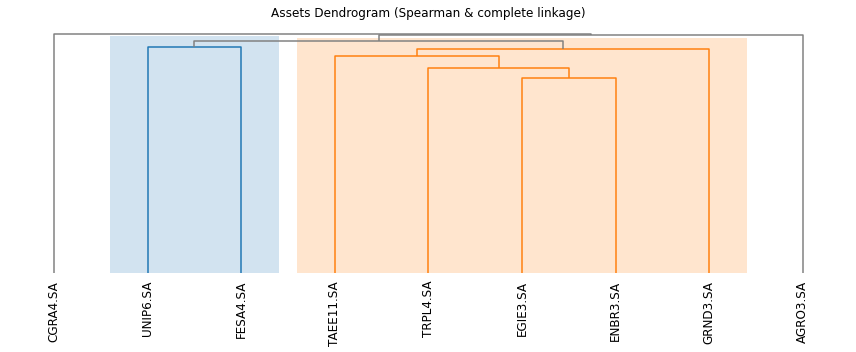

In [22]:
# Plotting Assets Clustering

ax = rp.plot_dendrogram(
    returns=log_train,
    codependence='spearman',
    linkage='complete',
    k=None,
    max_k=20,
    leaf_order=True,
    ax=None
)

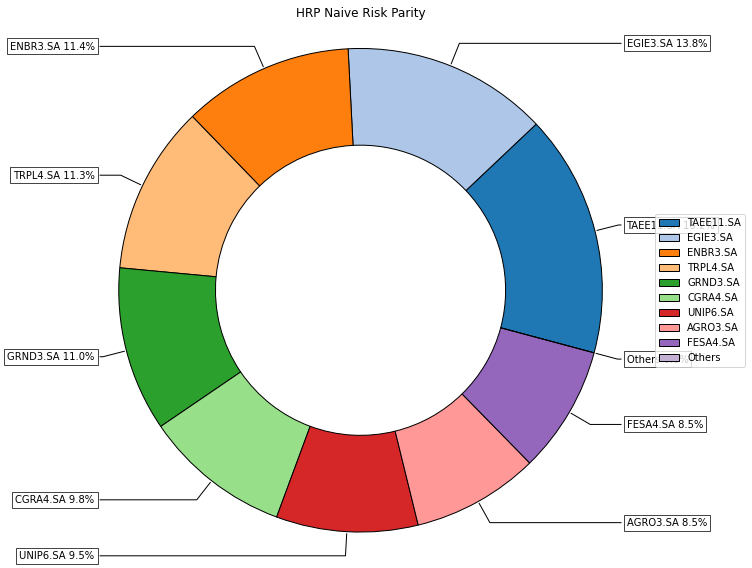

In [23]:
# Building the portfolio object
port = rp.HCPortfolio(returns=log_train)

# Estimate optimal portfolio

model='HRP' # Could be HRP or HERC
codependence = 'spearman' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0.09 # Risk free rate
linkage = 'complete' # Linkage method used to build clusters
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
obj = 'Sharpe'
hist = True

w = port.optimization(
    model=model,
    codependence=codependence,
    obj=obj,
    rm=rm,
    rf=rf,
    linkage=linkage,
    max_k=max_k,
    leaf_order=leaf_order,
    hist=hist
)

# Plotting the composition of the portfolio

ax = rp.plot_pie(
    w=w,
    title='HRP Naive Risk Parity',
    others=0.05,
    nrow=30,
    cmap="tab20",
    height=8,
    width=10,
    ax=None
)

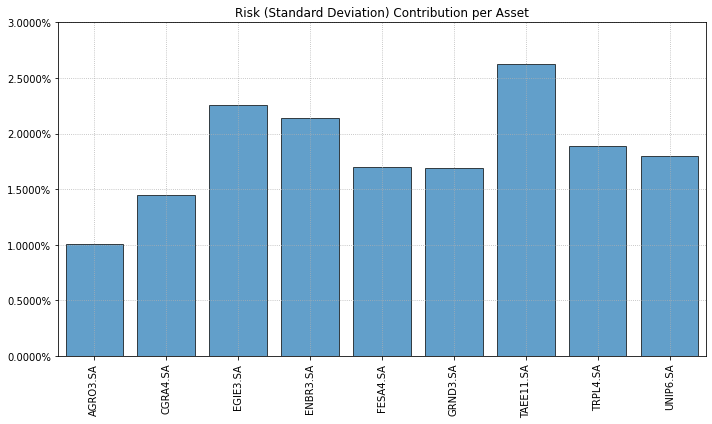

In [24]:
# Plotting the risk contribution per asset

mu = log_train.mean()
cov = log_train.cov() # Covariance matrix
returns = log_train # Returns of the assets

ax = rp.plot_risk_con(
    w=w,
    cov=cov,
    returns=returns,
    rm=rm,
    rf=0,
    alpha=0.05,
    color="tab:blue",
    height=6,
    width=10,
    t_factor=252,
    ax=None
)

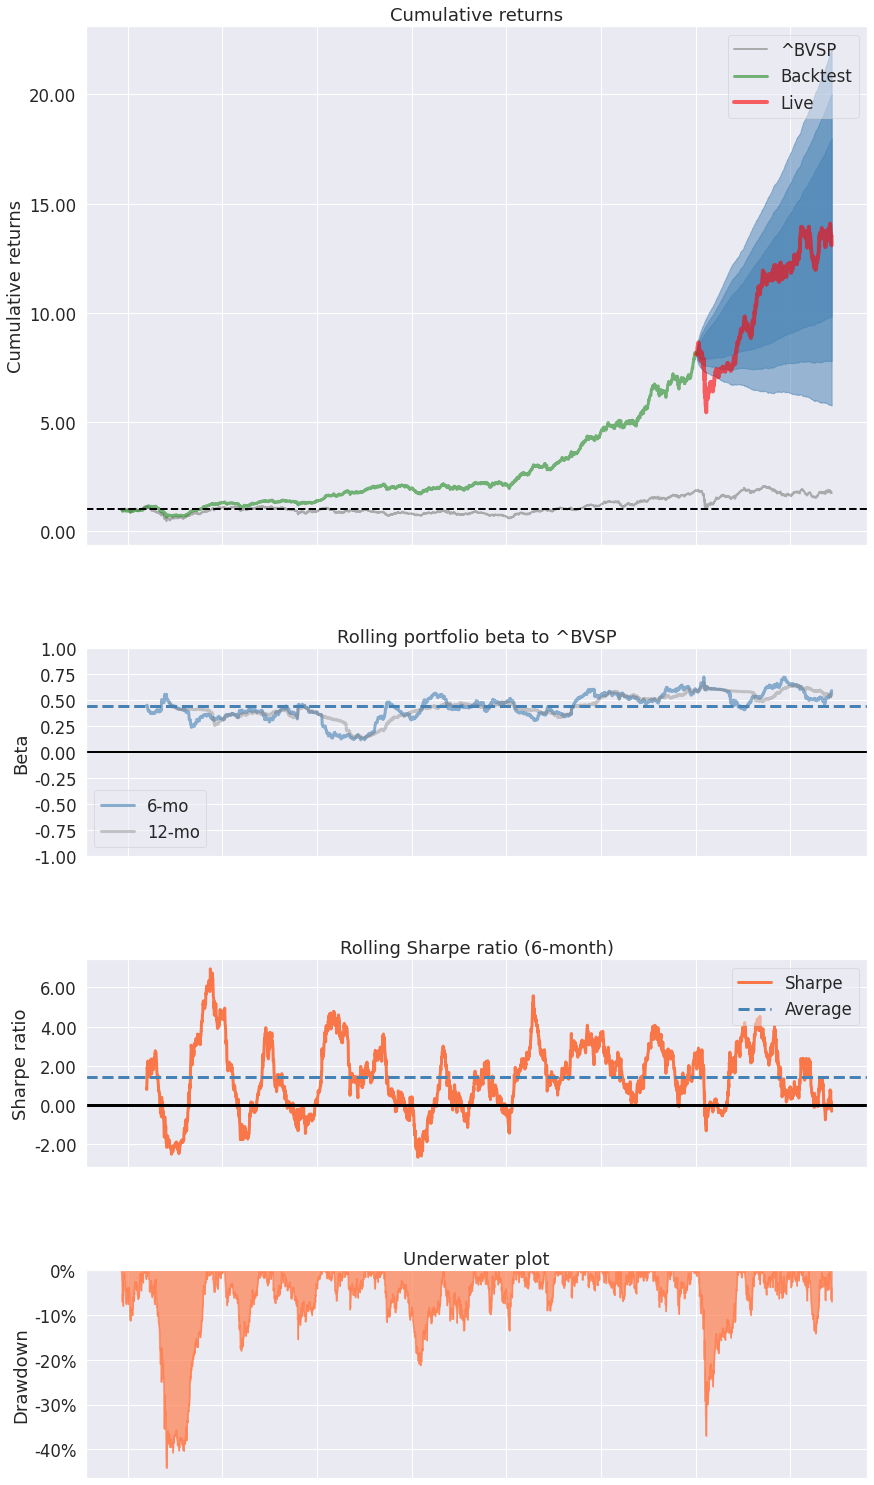

In [25]:
portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

test_ibv = data_ibv.pct_change().dropna().droplevel(level=0, axis=1)
test_ibv.index = test_ibv.index.tz_localize('America/Sao_Paulo') 

portfolio_return.index = portfolio_return.index.tz_localize('America/Sao_Paulo') 

test_date = portfolio_return.index[-710]

pf.create_simple_tear_sheet(
    portfolio_return,
    live_start_date=test_date,
    benchmark_rets=test_ibv['^BVSP']
)

In [26]:
############################################################
### Using All Period of Time to Optimize the Final Portfolio
############################################################

### Adjust All period data for final optimization
data = data.droplevel(level=0, axis=1)
log_data =  np.log1p(data.pct_change()).dropna()
raw_data = data.pct_change().dropna()


### Adjust Benchmark for final comparision
raw_ibv = data_ibv.pct_change().dropna().droplevel(level=0, axis=1)


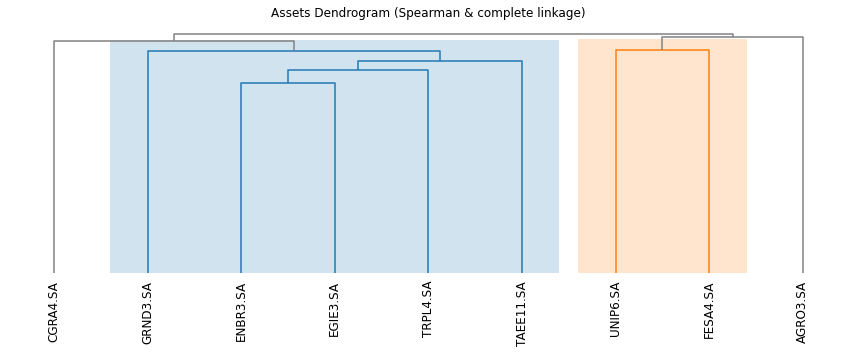

In [27]:
# Plotting Assets Clustering

ax = rp.plot_dendrogram(
    returns=log_data,
    codependence='spearman',
    linkage='complete',
    k=None,
    max_k=20,
    leaf_order=True,
    ax=None
)

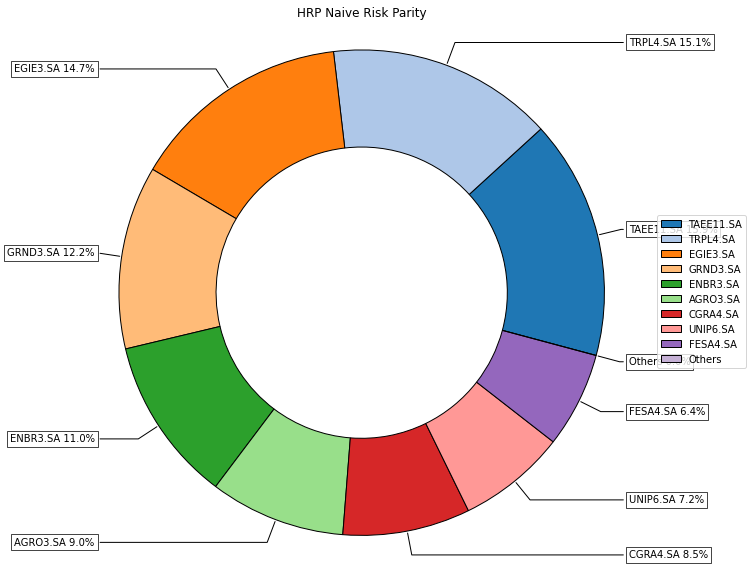

In [28]:
# Building the portfolio object
port = rp.HCPortfolio(returns=log_data)

# Estimate optimal portfolio

model='HRP' # Could be HRP or HERC
codependence = 'spearman' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0.09 # Risk free rate
linkage = 'complete' # Linkage method used to build clusters
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
obj = 'MinRisk'
hist = True

w = port.optimization(
    model=model,
    codependence=codependence,
    obj=obj,
    rm=rm,
    rf=rf,
    linkage=linkage,
    max_k=max_k,
    leaf_order=leaf_order,
    hist=hist
)

# Plotting the composition of the portfolio

ax = rp.plot_pie(
    w=w,
    title='HRP Naive Risk Parity',
    others=0.05,
    nrow=30,
    cmap="tab20",
    height=8,
    width=10,
    ax=None
)

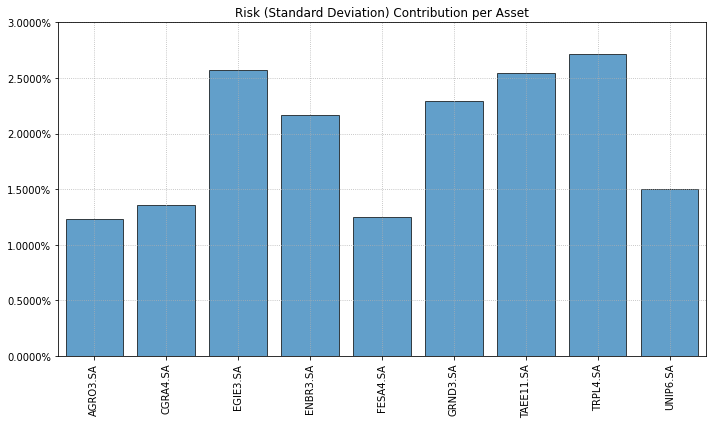

In [29]:
# Plotting the risk contribution per asset

mu = log_data.mean()
cov = log_data.cov() # Covariance matrix
returns = log_data # Returns of the assets

ax = rp.plot_risk_con(
    w=w,
    cov=cov,
    returns=returns,
    rm=rm,
    rf=0,
    alpha=0.05,
    color="tab:blue",
    height=6,
    width=10,
    t_factor=252,
    ax=None
)

Start date,2007-11-14
End date,2022-11-16
Total months,177
,Backtest
Annual return,18.408%
Cumulative returns,1111.305%
Annual volatility,17.602%
Sharpe ratio,1.05
Calmar ratio,0.44
Stability,0.96
Max drawdown,-41.644%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.64,2008-06-09,2008-10-27,2009-08-26,318
1,35.64,2020-01-23,2020-03-23,2020-11-19,216
2,22.30,2013-05-27,2014-03-10,2014-09-03,333
3,16.81,2010-01-19,2010-05-27,2010-10-04,185
4,14.54,2011-04-06,2011-08-08,2012-01-09,199


Stress Events,mean,min,max
Lehman,-0.43%,-5.07%,7.31%
US downgrade/European Debt Crisis,0.05%,-4.97%,2.77%
Fukushima,0.12%,-1.81%,1.56%
EZB IR Event,-0.12%,-4.95%,2.77%
Mar08,0.01%,-1.88%,2.13%
Sept08,-0.33%,-5.07%,7.31%
2009Q1,-0.04%,-1.92%,1.84%
2009Q2,0.45%,-2.32%,4.53%
Flash Crash,-0.41%,-1.64%,1.41%
Apr14,0.04%,-1.77%,3.11%


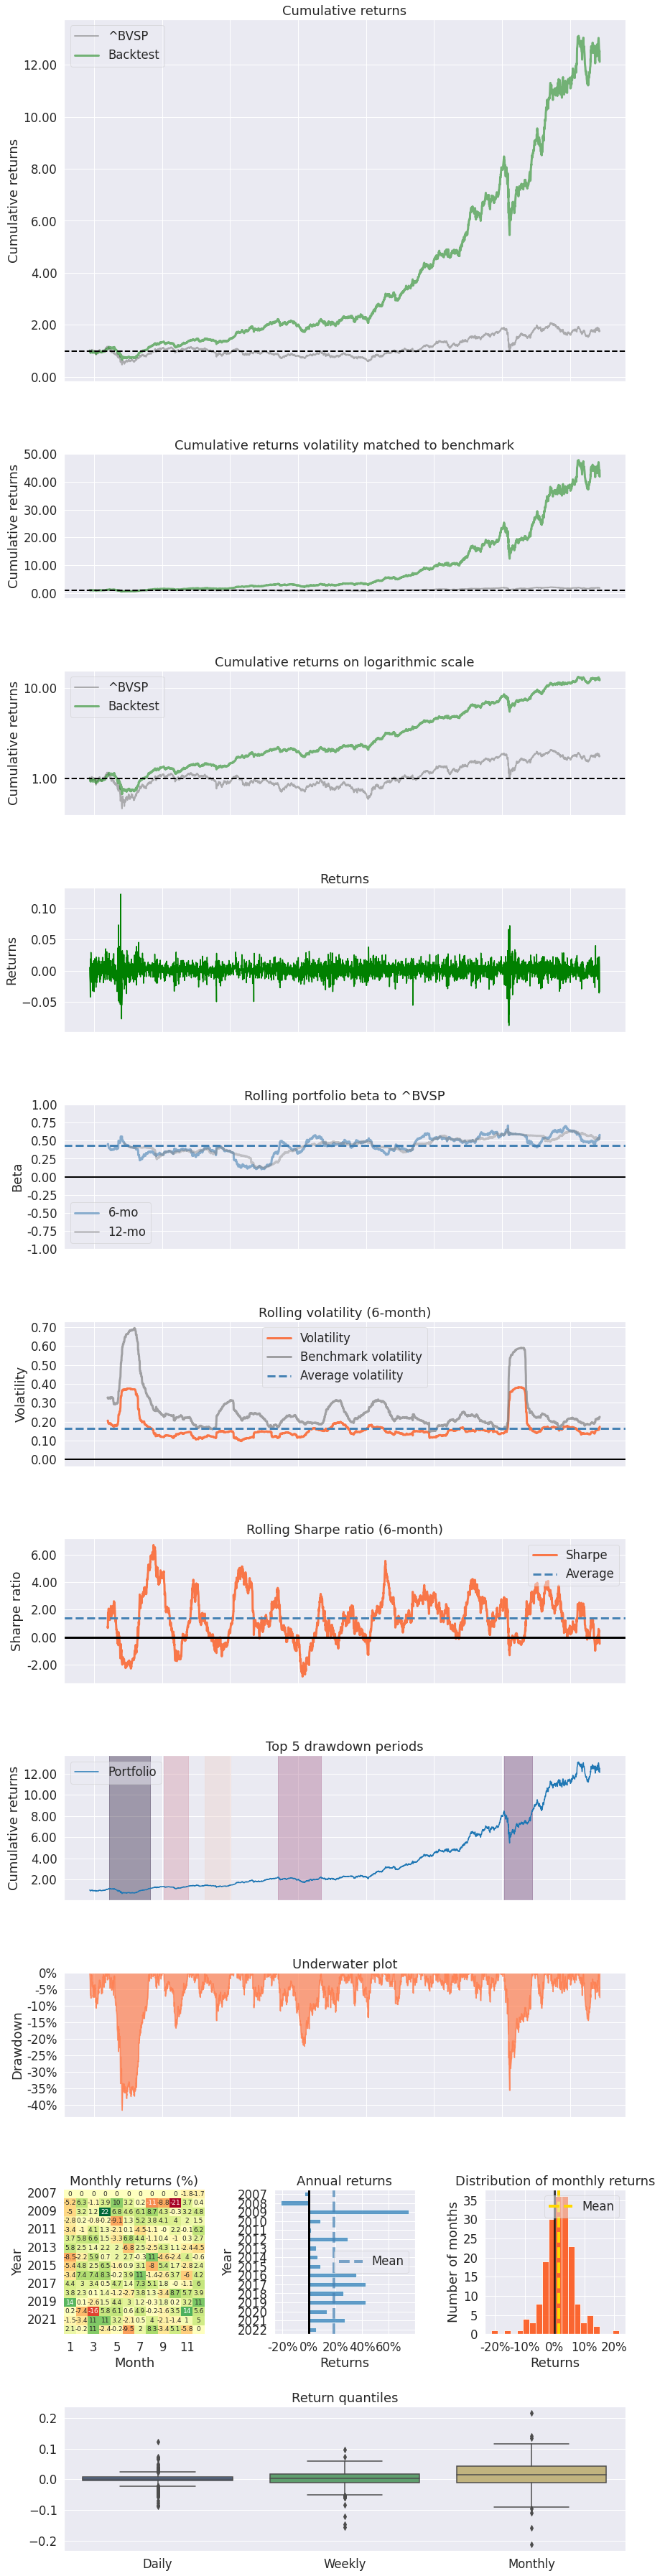

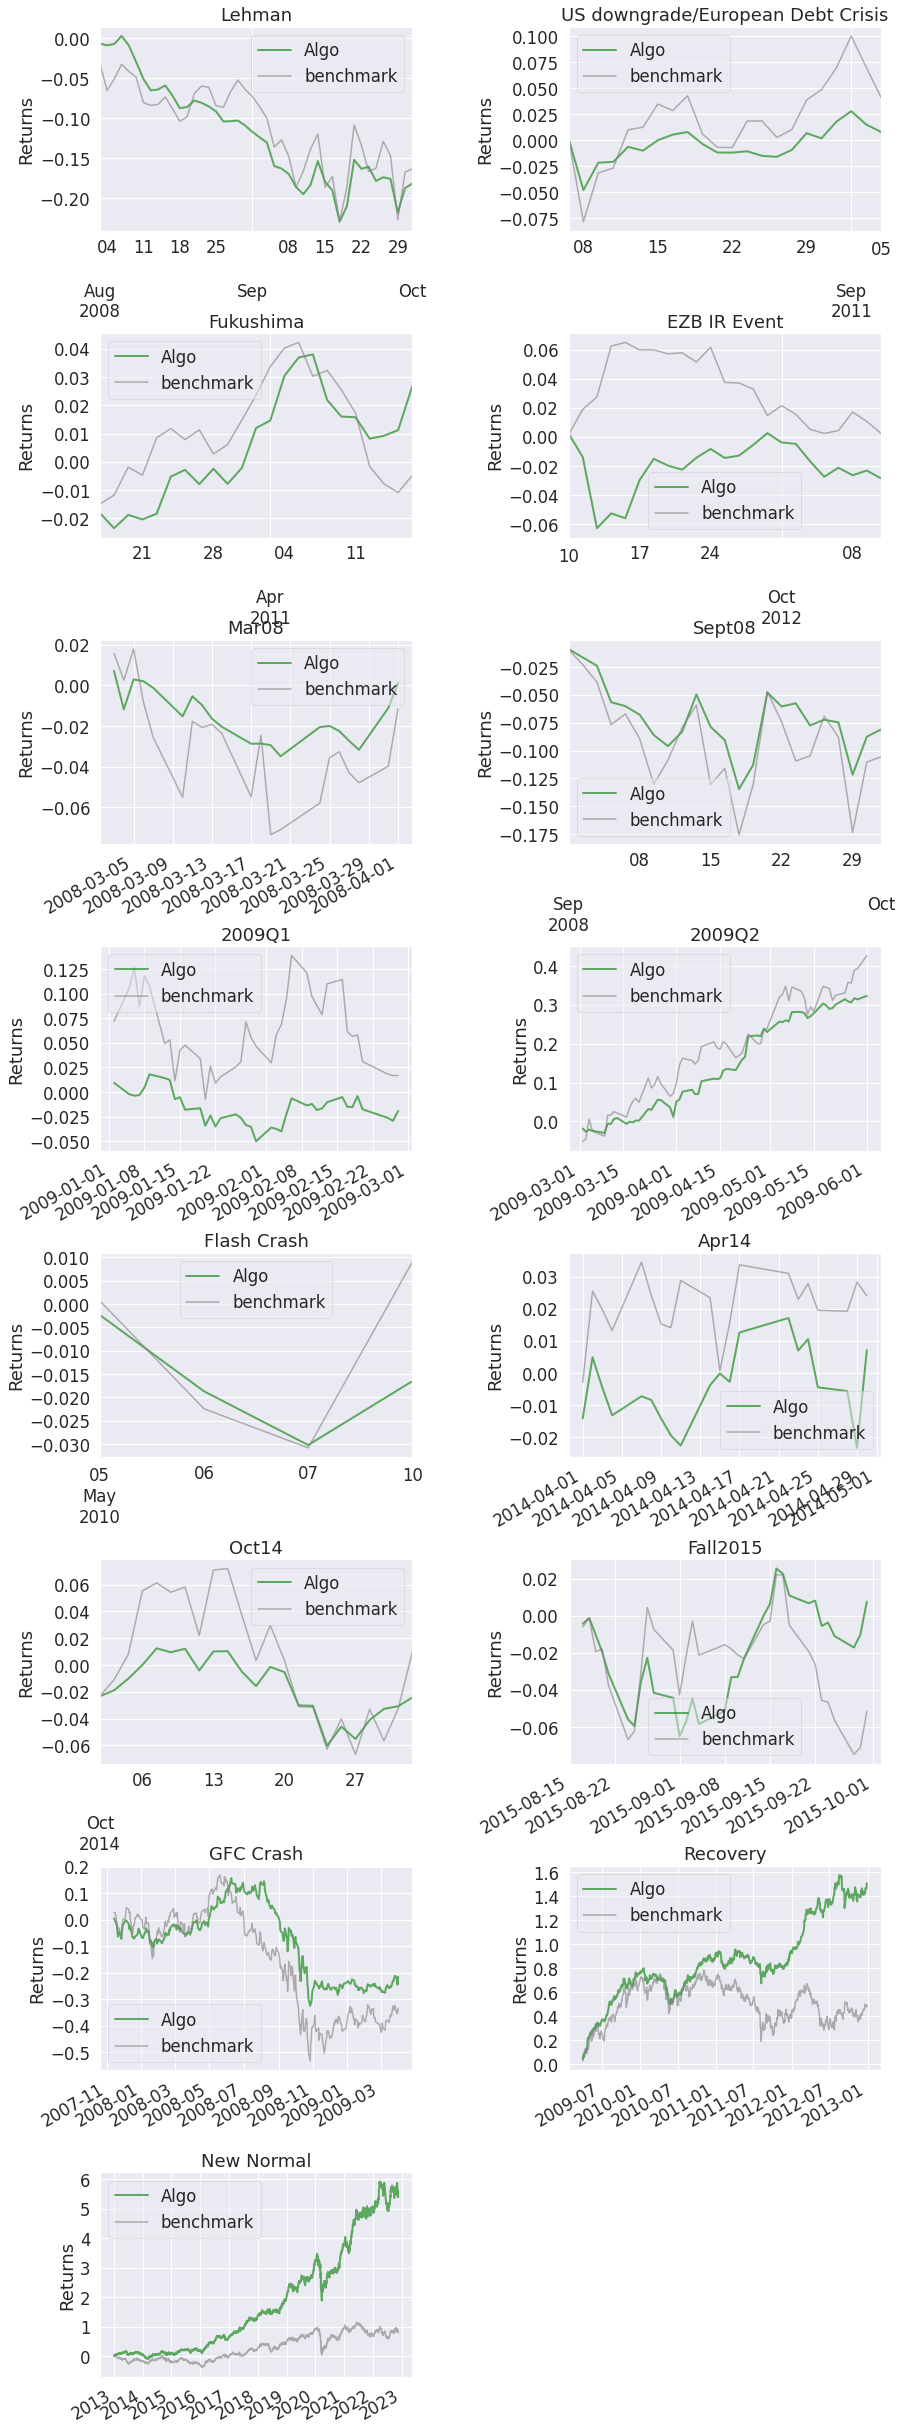

In [30]:
portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

pf.create_full_tear_sheet(
    portfolio_return,
    benchmark_rets=raw_ibv['^BVSP']
)

In [31]:
savings = 1500

preco = data.tail(1).T
preco.columns = ['preco']


my_port = (
    pd.DataFrame(
      {
      'ticker': w.index,
      'pesos': round(w['weights'] * 100, 1),
      'valor': round(w['weights'] * savings, 1),
      'preço': round(preco['preco'], 1),
      'qtd': round((w['weights'] * savings) / preco['preco'], 1),
      }
    )
    .sort_values(by=['pesos'], ascending=False)
    .reset_index(drop=True)
)

my_port

,ticker,pesos,valor,preço,qtd
0,TAEE11.SA,15.9,239.2,37.3,6.4
1,TRPL4.SA,15.1,226.1,23.0,9.8
2,EGIE3.SA,14.7,220.0,39.7,5.5
3,GRND3.SA,12.2,183.1,6.7,27.2
4,ENBR3.SA,11.0,165.0,21.1,7.8
5,AGRO3.SA,9.0,135.5,26.7,5.1
6,CGRA4.SA,8.5,127.4,29.6,4.3
7,UNIP6.SA,7.2,108.3,105.0,1.0
8,FESA4.SA,6.4,95.5,52.8,1.8


In [32]:
### Save the output inside Google Drive
my_port.to_csv('/content/drive/My Drive/data_lake/stocks_to_buy.csv', encoding='utf-8', index=False)